<a href="https://colab.research.google.com/github/JamesPeralta/Gymnos/blob/master/Neural-Network/Iteration1/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gymnos Iteration 1
## Gymnos iteration 1 will use a single stream 2D convolutional neural network. For each video we will be passing in only one frame and the AIs prediction will be based on the single frame. Therefore the first iteration only analyzes spatial patterns.


---
## Uploading all custom modules into the Instance

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 20.1MB/s 

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
# Upload the DataGenerator Module
data_generator_id = '1ICelbrinwuSz6E9I4UbriLy3icM9xNAH'
gymnos_DataGenerator = drive.CreateFile({'id': data_generator_id})
gymnos_DataGenerator.GetContentFile('GymnoDataGenerator_i1.py')

# Upload the HelperFunctions Module
helper_functions_id = '1PDgBPl0Z8a8bqbxdvODSdlbmjMexkV8f'
helper_functions = drive.CreateFile({'id': helper_functions_id})
helper_functions.GetContentFile('HelperFunctions_i1.py')

In [3]:
from google.colab import drive
import os
import csv

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


---
## Imports

In [4]:
import GymnoDataGenerator_i1 as gen
import HelperFunctions_i1 as helper

Using TensorFlow backend.


---
## Convert videos into Frames

In [0]:
destination = "/content/drive/My Drive/GYMNOS/Video Dataset/Frames/"

In [0]:
squat_videos = "/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/"
helper.extract_frames_from_directory(0, squat_videos, destination)


In [0]:
overhead_videos = "/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/"
helper.extract_frames_from_directory(2610, overhead_videos, destination)

---
## Create a labels and partitions CSVs


In [0]:
csv_location = "/content/drive/My Drive/GYMNOS/Video Dataset/"

In [0]:
helper.generate_labels_csv(csv_location, 2610, 4338)

In [6]:
labels_location = "/content/drive/My Drive/GYMNOS/Video Dataset/labels.csv"
helper.generate_partitions_csv(csv_location, labels_location)

3036
867
435


---
## Read in the labels and partitions CSVs


In [0]:
partition_location = "/content/drive/My Drive/GYMNOS/Video Dataset/partitions.csv"
labels_location = "/content/drive/My Drive/GYMNOS/Video Dataset/labels.csv"

partition = helper.read_partition_csv(partition_location)
labels = helper.read_labels_csv(labels_location)

In [10]:
print(len(partition["train"]))
print(len(partition["validation"]))
print(len(partition["test"]))

3036
867
435


--- 
## Initialize the DataGenerator

In [0]:
import matplotlib.pyplot as plt

In [0]:
# Parameters
params = {'data_location': "/content/drive/My Drive/GYMNOS/Video Dataset/Frames/",
          'dim': (224, 224, 3),
          'batch_size': 64,
          'n_classes': 2,
          'shuffle': True}

train_generator = gen.DataGenerator(partition["train"], labels, **params)
validation_generator = gen.DataGenerator(partition["validation"], labels, **params)

In [0]:
images, labels = train_generator.__getitem__(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

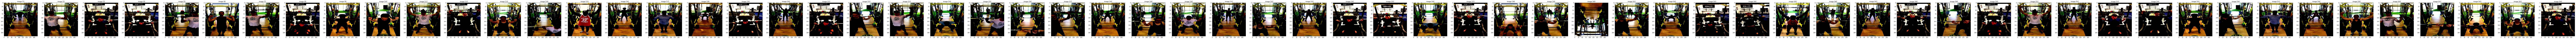

In [15]:
helper.show_images(images)

---
## Add TPU Support

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.train import RMSPropOptimizer
from tensorflow.keras.losses import binary_crossentropy

---
## Create the model


In [28]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    # include_top=False to remove the top layer

# Freeze all of the layers from the Conv base because we are performing transfer learning on
for layer in base_model.layers:
  layer.trainable = False
  
for layer in base_model.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0781bdafd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0781b8b0b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0781b8b208> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f0781b951d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0781b8bc18> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0781b31e10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f0781ae7400> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0781ae73c8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0781b19048> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0781ab3eb8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f0781a80b38> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [0]:
model = Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 25,693,186
Non-trainable params: 14,714,688
_________________________________________________________________


In [24]:
# Convert model to TPU version
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
            model,
            strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

INFO:tensorflow:Querying Tensorflow master (grpc://10.39.249.114:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 8660174596423847753)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17668524552696233238)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 10579994295477271713)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9180807461029634372)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 8759246315970496063)
INFO:tensorflow:*** Available Device: _DeviceAttributes

In [0]:
model.compile(optimizer=RMSPropOptimizer(learning_rate=1e-3), 
              loss=binary_crossentropy,
              metrics=['acc'])

In [26]:
train_generator.__len__()

47

In [32]:
history = model.fit_generator(train_generator,
                                  steps_per_epoch=train_generator.__len__(),
                                  epochs=30,
                                  validation_data=validation_generator,
                                  validation_steps=validation_generator.__len__(),
                                  verbose=1)

Epoch 1/30
47/47 [==============================] - 626s 13s/step - loss: 0.7079 - acc: 0.6237 - val_loss: 0.5222 - val_acc: 0.7350
Epoch 2/30
47/47 [==============================] - 81s 2s/step - loss: 0.6361 - acc: 0.6775 - val_loss: 0.4233 - val_acc: 0.7969
Epoch 3/30
47/47 [==============================] - 81s 2s/step - loss: 0.5013 - acc: 0.7718 - val_loss: 0.2624 - val_acc: 0.8828
Epoch 4/30
47/47 [==============================] - 81s 2s/step - loss: 0.2482 - acc: 0.8976 - val_loss: 0.0770 - val_acc: 0.9802
Epoch 5/30
47/47 [==============================] - 81s 2s/step - loss: 0.1126 - acc: 0.9551 - val_loss: 0.0540 - val_acc: 0.9820
Epoch 6/30
47/47 [==============================] - 81s 2s/step - loss: 0.0817 - acc: 0.9697 - val_loss: 0.0281 - val_acc: 0.9940
Epoch 7/30
47/47 [==============================] - 80s 2s/step - loss: 0.0466 - acc: 0.9840 - val_loss: 0.2911 - val_acc: 0.8846
Epoch 8/30
47/47 [==============================] - 81s 2s/step - loss: 0.0332 - acc: 0.